#### Required Python Modules

In [1]:
## === Changing the directory ===
import os
os.chdir("../")

In [2]:
## === Python Modules ===
from typing import List, Dict
from pathlib import Path
import numpy as np
import pandas as pd
from utils import data_logger, embed_logger, match_logger

### Creating the Dataset

⚠️ **Important Note:**  
The code in this section (up to and including the saving step) should be **run only once**.

It initializes, saves, **and returns** your **base dataset** containing all product names, descriptions, and tags.

After the initial run:
- Do **not** re-run this cell, as it may overwrite your existing dataset.
- For future operations, **load and return** the dataset from disk instead of recreating it.
- If you need to add new products later, append them manually or through an update script then re-save and re-return the updated dataset.

In [3]:
## === Sample Mock Dataset ===
products: List[Dict[str, str | List[str]]] = [
    {"name": "Boho Dress", "desc": "Flowy, earthy tones for festival vibes", "tags": ["boho", "cozy"]},
    {"name": "Street Hoodie", "desc": "Oversized hoodie with graffiti design for an urban street look", "tags": ["urban", "casual"]},
    {"name": "Silk Gown", "desc": "Elegant floor-length gown perfect for evening events", "tags": ["elegant", "formal"]},
    {"name": "Denim Jacket", "desc": "Classic blue denim with rugged edges for a cool, edgy vibe", "tags": ["edgy", "casual"]},
    {"name": "Athleisure Set", "desc": "Breathable co-ord for active and energetic days", "tags": ["sporty", "energetic"]},
    {"name": "Cozy Sweater", "desc": "Soft wool knit with warm neutral tones", "tags": ["cozy", "minimal"]},
    {"name": "Chic Blazer", "desc": "Tailored fit blazer for a modern, professional look", "tags": ["formal", "chic"]},
    {"name": "Festival Kimono", "desc": "Bright patterns and light fabric for summer festivals", "tags": ["boho", "fun"]},
    {"name": "Leather Boots", "desc": "High-ankle boots with a matte finish for a confident statement", "tags": ["bold", "edgy"]},
    {"name": "Cotton Tee", "desc": "Simple white t-shirt made from organic cotton", "tags": ["minimal", "casual"]}
]

In [4]:
## === Converting it to a pandas DataFrame ===
dataset = pd.DataFrame(
    data = products
)

dataset.head()

,name,desc,tags
0,Boho Dress,"Flowy, earthy tones for festival vibes","[boho, cozy]"
1,Street Hoodie,Oversized hoodie with graffiti design for an u...,"[urban, casual]"
2,Silk Gown,Elegant floor-length gown perfect for evening ...,"[elegant, formal]"
3,Denim Jacket,Classic blue denim with rugged edges for a coo...,"[edgy, casual]"
4,Athleisure Set,Breathable co-ord for active and energetic days,"[sporty, energetic]"


#### Saving the dataset

In [5]:
## === Folder path to save the data ===
save_data_folder_path: Path = Path("data/raw")

In [6]:
## === Saving the dataset seprately ===
def save_dataset(
        dataset: pd.DataFrame,
        folder_path: Path,
        file_name: str
) -> pd.DataFrame:
    """
    Saves the dataset to both CSV and JSON formats inside the given folder.

    Args:
        folder_path (Path): Directory path where data will be saved.
        dataset (pd.DataFrame): The DataFrame containing product data.
        filename (str): Base name for the saved files (without extension).

    Returns:
        str: Path of the saved file.
    """
    try:
        ## === Making sure that the folder exists ===
        os.makedirs(
            name = folder_path,
            exist_ok = True
        )

        ## === Defining the path ===
        file_path: Path = folder_path / f"{file_name}.csv"

        data_logger.info(f"Started saving file at: {file_path}")
        print(f"Started saving file at: {file_path}")

        ## === Saving the csv file ===
        dataset.to_csv(
            file_path,
            index = False
        )
        data_logger.info(f"Successfully saved file at: {file_path}")
        print(f"Successfully saved file at: {file_path}")

        return dataset

    except Exception as e:
        raise ValueError(f"Error saving the dataset: {e}")

#### Loading the dataset

In [7]:
## === Function to load the data ===
def load_data(
        folder_path: Path,
        file_name: str
) -> pd.DataFrame:
    """
    Loads the pre-existing dataset

    Args:
        - folder_path (Path): Path to the folder.
        - file_name (str): Name of the file
    """
    try:
        ## === Defining the path ===
        file_path: Path = folder_path / f"{file_name}.csv"

        ## === Loading the Dataset ===
        dataset = pd.read_csv(
            file_path
        )

        ## === Logging ===
        data_logger.info(f"Successfully loaded data from the file: {file_path}")
        print(f"Successfully loaded data from the file: {file_path}")

        return dataset
    
    except Exception as e:
        ## === Logger ===
        data_logger.info(f"Error Loading data from the path {file_path}: {e}")
        print(f"Error Loading data from the path {file_path}: {e}")

##### Loading the raw dataset.

In [8]:
if save_data_folder_path.exists():
    raw_dataset = load_data(
        folder_path = save_data_folder_path,
        file_name = "data"
    )

else:
    raw_dataset = save_dataset(
        dataset = dataset,
        folder_path = save_data_folder_path,
        file_name = "data"
    )

Successfully loaded data from the file: data\raw\data.csv


##### Loading the embedded dataset

In [9]:
## === Folder path to the embedded dataset ===
embedded_dataset_folder_path: Path = Path("data/embeddings")

In [10]:
## === Loading the embedded dataset if it exists ===
if embedded_dataset_folder_path.exists():
    embedded_dataset = load_data(
        folder_path = embedded_dataset_folder_path,
        file_name = "data"
    )

else:
    data_logger.info(f"Embedding data done not exist at path {embedded_dataset_folder_path}")
    print(f"Embedding data done not exist at path {embedded_dataset_folder_path}")

Successfully loaded data from the file: data\embeddings\data.csv


### Comparing Existing Embeddings

This function compares the **raw dataset** with the **existing embeddings dataset** and returns only the newly added rows that don’t have embeddings yet.

#### Purpose
- Helps **reduce the number of OpenAI API calls**, saving both **time and cost**.
- Enables **incremental embedding updates**, meaning only new or updated items are embedded.
- Ideal for **scaling** as your product catalog or business grows no need to re-embed everything on each run.

In [11]:
## === Function to return the new data ===
def get_new_rows(
        raw_dataset: pd.DataFrame,
        embd_dataset: pd.DataFrame
) -> pd.DataFrame:
    """
    Compares the raw dataset with the existing embeddings dataset
    and returns only those product rows which need embeddings.

    Args:
        raw_dataset (pd.DataFrame): Raw dataset containing all products with their descriptions.
        embd_dataset (pd.DataFrame): Embedding dataset containing already embedded products.

    Returns:
        pd.DataFrame: A subset of raw_dataset containing only the newly added (unembedded) products.
    """
    try:
        ## === Extract unique product names ===
        all_products = set(raw_dataset["name"])
        existing_products = set(embd_dataset["name"])

        ## === Identify new product names ===
        new_product_names = all_products - existing_products

        ## === Handle case: no new products ===
        if not new_product_names:
            embed_logger.info("All items already have embeddings. No new rows found.")
            print("All items already have embeddings. No new rows found.")
            return pd.DataFrame(
                columns = raw_dataset.columns
            )

        ## === Filter raw dataset for only new products ===
        new_rows = raw_dataset[
            raw_dataset["name"].isin(new_product_names)
        ].reset_index(drop=True)

        ## === Logging ===
        embed_logger.info(f"Found {len(new_rows)} new items to embed.")
        print(f"Found {len(new_rows)} new items to embed.")

        return new_rows

    except Exception as e:
        raise ValueError(f"Error comparing datasets: {e}")

In [12]:
if not embedded_dataset.empty:
    new_rows = get_new_rows(
        raw_dataset = raw_dataset,
        embd_dataset = embedded_dataset
    )
else:
    new_rows = raw_dataset

All items already have embeddings. No new rows found.


### Creating Embeddings for Data Description

This section generates **vector embeddings** for each product description using OpenAI’s `text-embedding-ada-002` model.

#### Purpose
- Converts product descriptions into numerical vectors that capture **semantic meaning** (the "vibe" or style).  
- These embeddings are later used to calculate **cosine similarity** between user queries and product descriptions.  
- Enables the recommendation engine to match based on *meaning*, not just keywords.

In [13]:
## === Python Packages ===
from openai import OpenAI
import time
from dotenv import load_dotenv

In [14]:
## === Importing the api keys using dotenv ===
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [15]:
## === Initialize OpenAI Client ===
client = OpenAI(
    api_key = OPENAI_API_KEY
)

In [16]:
# === Generate Embedding ===
def get_embeddings(
        text: str
):
    """
    Generates a vector embedding for a given input text using OpenAI's `text-embedding-ada-002` model.

    Args:
        text (str): Input string or sentence to embed.

    Returns:
        list[float]: Numerical vector representing the semantic meaning of the text.
    """
    try:
        start_time = time.time()

        # === API Call ===
        response = client.embeddings.create(
            input = text,
            model = "text-embedding-ada-002"
        )

        latency = time.time() - start_time
        embed_logger.info(f"Embedding generated | Tokens: {len(text.split())} | Time: {latency:.2f}s")
        print(f"Embedding generated | Tokens: {len(text.split())} | Time: {latency:.2f}s")

        # === Return the embedding vector ===
        return response.data[0].embedding

    except Exception as e:
        embed_logger.info(f"Embedding generation failed: {e}")
        print(f"Embedding generation failed: {e}")
        return None

In [17]:
## === Generating Embeddings ===
def apply_embeddings(
        dataset: pd.DataFrame
) -> pd.DataFrame:
    """
    Generates vector embeddings for each product description in the dataset using the pre-defined get_embeddings() function.

    Args:
        dataset (pd.DataFrame): DataFrame containing product descriptions. Must include the 'desc' column.

    Returns:
        pd.DataFrame: DataFrame with 'name' and 'embeddings' columns.
    """
    try:
        ## === Validate required column ===
        if "desc" not in dataset.columns:
            embed_logger.info("The dataset must contain a 'desc' column for embedding generation.")
            raise KeyError("The dataset must contain a 'desc' column for embedding generation.")
        
        ## === Generate embeddings for each description ===
        dataset["embeddings"] = dataset["desc"].apply(get_embeddings)

        ## === Logger ===
        embed_logger.info(f"Generated embeddings for {len(dataset)} products.")
        print(f"Generated embeddings for {len(dataset)} products.")

        ## === Return only relevant columns ===
        return dataset[["name", "embeddings"]]
    
    except Exception as e:
        raise ValueError(f"")

In [18]:
## === Saving embeddings in a different file ===
embedded_dataset_folder_path: Path = Path("data/embeddings")

save_dataset(
    dataset = new_rows,
    folder_path = embedded_dataset_folder_path,
    file_name = "data"
)

Started saving file at: data\embeddings\data.csv
Successfully saved file at: data\embeddings\data.csv


,name,desc,tags


##### Updating the embeddings

In [19]:
## === Function to Update and Save Embeddings ===
def save_updated_embeddings(
        embd_dataset: pd.DataFrame,
        new_embeds_df: pd.DataFrame,
        save_path: Path
) -> pd.DataFrame:
    """
    Appends newly created embeddings to the already loaded embeddings dataset and saves the updated dataset back to disk.

    Args:
        embd_dataset (pd.DataFrame): The existing embeddings dataset.
        new_embeds_df (pd.DataFrame): The new embeddings DataFrame to append.
        save_path (Path): Path where the updated embeddings CSV should be saved.

    Returns:
        pd.DataFrame: Updated embeddings DataFrame (old + new combined).
    """
    try:
        ## === File Path ===
        file_path: Path = save_path / "data.csv"

        ## === Combine existing and new embeddings ===
        updated_embds = pd.concat(
            [embd_dataset, new_embeds_df],
            ignore_index = True
        )

        ## === Save updated embeddings ===
        updated_embds.to_csv(
            file_path,
            index = False
        )

        ## === Logger ===
        embed_logger.info(f"Saved updated embeddings with {len(updated_embds)} total records.")
        print(f"Saved updated embeddings with {len(updated_embds)} total records.")

        return updated_embds

    except Exception as e:
        ## === Logger ===
        embed_logger.info(f"Error while saving updated embeddings: {e}")
        raise ValueError(f"Error while saving updated embeddings: {e}")

##### Saving or Updating the embeddings.

In [20]:
## === Saving embeddings in a different file ===
embedded_dataset_folder_path: Path = Path("data/embeddings")

In [21]:
## === Updating if the embedding folder exists ===
if embedded_dataset_folder_path.exists():
    ## === Creating embeddings ===
    new_embds = apply_embeddings(
        dataset = new_rows
    )

    ## === Updating the dataset ===
    dataset = save_updated_embeddings(
        embd_dataset = embedded_dataset,
        new_embeds_df = new_embds,
        save_path = embedded_dataset_folder_path
    )

## === Saving if the embedding folder doesn't exist ===
else:
    ## === Creating embeddings ===
    new_embds = apply_embeddings(
        dataset = new_rows
    )

    ## === saving the dataset ===
    dataset = save_dataset(
        dataset = new_embds,
        folder_path = embedded_dataset_folder_path,
        file_name = "data"
    )

Generated embeddings for 0 products.
Saved updated embeddings with 10 total records.


### Similarity Search using Cosine Similarity

This section performs **semantic similarity search** between the user’s vibe query and all product embeddings stored in the dataset.  
By converting both the query and product descriptions into vector embeddings, we use **cosine similarity** to measure how closely their meanings align.

#### Purpose
- To find products that *“feel” similar* to the user’s vibe query (e.g., *“energetic urban chic”*).  
- Enables **semantic matching** understanding meaning beyond exact keywords.  
- Forms the core of the **Vibe Matcher recommendation engine.**

✅ **Tip:**  
A cosine similarity score closer to `1.0` indicates a stronger match in meaning.

In [22]:
## === Python Modules ===
from sklearn.metrics.pairwise import cosine_similarity
import ast

In [23]:
## === Computing Cosine Similarities (with sklearn + Thresholding) ===
def get_top_similar_products(
        query: str,
        embd_dataset: pd.DataFrame,
        top_k: int = 3,
        threshold: float = 0.70
) -> pd.DataFrame | str:
    """
    Finds the top-k most similar products based on cosine similarity between the query embedding and existing product embeddings.

    Args:
        query (str): User's vibe or descriptive text query.
        embd_dataset (pd.DataFrame): Dataset containing product names and embeddings.
        top_k (int, optional): Number of top matching products to return. Default is 3.
        threshold (float, optional): Minimum similarity score to consider a valid match. Default is 0.70.

    Returns:
        pd.DataFrame or str: DataFrame of top-k similar products with similarity scores, or a fallback message if no products exceed the threshold.
    """
    try:
        ## === Validate required columns ===
        if embd_dataset.empty:
            match_logger.error("Embeddings dataset is empty.")
            raise ValueError("Embeddings dataset is empty. Please load embeddings first.")

        if "embeddings" not in embd_dataset.columns:
            match_logger.error("'embeddings' column not found in embd_dataset.")
            raise KeyError("The embeddings column is missing in embd_dataset.")

        ## === Convert string embeddings to lists (if needed) ===
        if isinstance(embd_dataset["embeddings"].iloc[0], str):
            embd_dataset["embeddings"] = embd_dataset["embeddings"].apply(ast.literal_eval)
            match_logger.info("Converted stringified embeddings to lists.")

        ## === Generate query embedding ===
        query_embedding = get_embeddings(query)
        match_logger.info(f"Generated query embedding for: '{query}'")

        ## === Convert product embeddings to NumPy array ===
        product_embeddings = np.vstack(embd_dataset["embeddings"].values)

        ## === Compute cosine similarities using sklearn ===
        similarities = cosine_similarity(
            [query_embedding],
            product_embeddings
        )[0]

        ## === Create a results DataFrame ===
        results = embd_dataset.copy()
        results["similarity"] = similarities

        ## === Filter results above the threshold ===
        filtered_results = results[
            results["similarity"] >= threshold
        ]

        if filtered_results.empty:
            match_logger.info(f"No strong matches found for query: '{query}' (Threshold: {threshold})")
            print(f"No strong matches found for: '{query}'. Try a different vibe or phrasing.")
            return "No strong vibe matches found. Try refining your query."

        ## === Sort and return top-k ===
        top_results = (
            filtered_results.sort_values(by = "similarity", ascending = False)
                            .head(top_k)
                            .reset_index(drop = True)
        )

        match_logger.info(f"Top {len(top_results)} results generated successfully for query: '{query}'")
        print(f"Top {len(top_results)} results for query: '{query}' (Threshold: {threshold})")

        return top_results[["name", "similarity"]]

    except Exception as e:
        match_logger.error(f"Error computing cosine similarities: {e}")
        raise ValueError(f"Error computing cosine similarities: {e}")

In [24]:
## === Using an example query ===
get_top_similar_products(
    query = "energetic urban chic",
    embd_dataset = dataset
)

Embedding generated | Tokens: 3 | Time: 2.64s
Top 3 results for query: 'energetic urban chic' (Threshold: 0.7)


,name,similarity
0,Street Hoodie,0.840607
1,Athleisure Set,0.834934
2,Boho Dress,0.823926


#### Logging the results as a csv file

In [25]:
## === Python Modules ===
import time
from datetime import datetime

In [26]:
## === Defining the Evaluation Log Path ===
EVAL_LOG_PATH = Path("logs/query_eval_log.csv")
EVAL_LOG_PATH.parent.mkdir(
    parents = True,
    exist_ok = True
)

In [27]:
## === Running Query and Evaluating Performance ===
def run_query_and_evaluate(
        query: str,
        embd_dataset: pd.DataFrame,
        top_k: int = 3,
        threshold: float = 0.70
):
    """
    Uses the get_top_similar_products() helper to evaluate query performance,
    log latency, and store metrics in a structured CSV file.

    Args:
        query (str): User's vibe or descriptive text query.
        embd_dataset (pd.DataFrame): Dataset containing product names and embeddings.
        top_k (int): Number of top matching products to return. Default is 3.
        threshold (float): Minimum similarity score to consider a valid match. Default is 0.70.

    Returns:
        pd.DataFrame or None: Similarity results or None if an error occurs.
    """
    try:
        ## === Start timer ===
        start_time = time.time()
        match_logger.info(f"Running evaluation for query: '{query}'")

        ## === Run cosine similarity search (helper call) ===
        results = get_top_similar_products(
            query = query,
            embd_dataset = embd_dataset,
            top_k = top_k,
            threshold = threshold
        )

        ## === Compute latency ===
        latency = round(time.time() - start_time, 2)

        ## === Initialize log entry ===
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        if isinstance(results, str):
            log_entry = {
                "timestamp": timestamp,
                "query": query,
                "results": results["name"].values,
                "threshold": threshold,
                "num_results": 0,
                "good_matches": 0,
                "avg_similarity": None,
                "latency_sec": latency,
                "status": "No strong match"
            }
            match_logger.info(f"No strong matches for '{query}' (Threshold: {threshold})")

        else:
            num_results = len(results)
            good_matches = (results["similarity"] > threshold).sum()
            avg_similarity = round(results["similarity"].mean(), 3)

            log_entry = {
                "timestamp": timestamp,
                "query": query,
                "results": results["name"].values,
                "threshold": threshold,
                "num_results": num_results,
                "good_matches": int(good_matches),
                "avg_similarity": avg_similarity,
                "latency_sec": latency,
                "status": "Success"
            }

            match_logger.info(f"Query '{query}' | {num_results} results | Avg Sim: {avg_similarity} | Latency: {latency}s")

        ## === Save metrics to CSV ===
        log_df = pd.DataFrame([log_entry])

        ## === Create or append to CSV ===
        if not EVAL_LOG_PATH.exists():
            log_df.to_csv(
                EVAL_LOG_PATH,
                index = False
            )
            match_logger.info("Created new evaluation log file.")

        else:
            log_df.to_csv(
                EVAL_LOG_PATH,
                mode = "a",
                header = False,
                index = False
            )
            match_logger.info(f"Appended evaluation log for query: '{query}'")

        ## === Console output ===
        print(f"Query '{query}' completed in {latency}s -> Status: {log_entry['status']}")
        return results

    except Exception as e:
        latency = round(time.time() - start_time, 2)
        match_logger.error(f"Error evaluating query '{query}': {e}")

        ## === Log error row ===
        log_entry = {
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "query": query,
            "top_k": top_k,
            "threshold": threshold,
            "num_results": 0,
            "good_matches": 0,
            "avg_similarity": None,
            "latency_sec": latency,
            "status": f"Error: {e}"
        }
        pd.DataFrame([log_entry]).to_csv(
            EVAL_LOG_PATH,
            mode = "a",
            header = False,
            index = False
        )

        return None

In [28]:
queries = [
    "energetic urban chic",
    "cozy winter comfort"
]

In [29]:
for query in queries:
    _ = run_query_and_evaluate(
        query = query,
        embd_dataset = dataset
    )

Embedding generated | Tokens: 3 | Time: 0.39s
Top 3 results for query: 'energetic urban chic' (Threshold: 0.7)
Query 'energetic urban chic' completed in 0.4s -> Status: Success
Embedding generated | Tokens: 3 | Time: 0.53s
Top 3 results for query: 'cozy winter comfort' (Threshold: 0.7)
Query 'cozy winter comfort' completed in 0.53s -> Status: Success


In [30]:
queries = [
    "luxury evening glamour",
    "techwear cyberpunk neon"
]

In [31]:
for query in queries:
    _ = run_query_and_evaluate(
        query = query,
        embd_dataset = dataset
    )

Embedding generated | Tokens: 3 | Time: 1.20s
Top 3 results for query: 'luxury evening glamour' (Threshold: 0.7)
Query 'luxury evening glamour' completed in 1.2s -> Status: Success
Embedding generated | Tokens: 3 | Time: 0.53s
Top 3 results for query: 'techwear cyberpunk neon' (Threshold: 0.7)
Query 'techwear cyberpunk neon' completed in 0.53s -> Status: Success


#### Avg. Latency and Latency per query

In [33]:
## === Python Module ===
import matplotlib.pyplot as plt

In [34]:
## === Defining the Evaluation Log Path ===
EVAL_LOG_PATH = Path("logs/query_eval_log.csv")

In [35]:
## === Plotting Latency Evaluation Metrics ===
def plot_query_latency(
        log_path: Path = EVAL_LOG_PATH
) -> None:
    """
    Reads the evaluation log CSV and visualizes:
        1. Latency per query
        2. Displays average latency across all queries in the title

    Args:
        log_path (Path): Path to the CSV file containing query evaluation logs.

    Returns:
        None: Displays a matplotlib figure.
    """
    try:
        ## === Load log CSV ===
        df = pd.read_csv(log_path)

        ## === Ensure required column exists ===
        if "latency_sec" not in df.columns:
            print("'latency_sec' column missing in log file.")
            return

        ## === Compute average latency ===
        avg_latency = round(df["latency_sec"].mean(), 2)

        ## === Plot setup ===
        plt.figure(figsize = (10, 6))
        plt.bar(
            df["query"],
            df["latency_sec"],
            color = "#5DADE2",
            edgecolor = "black"
        )

        ## === Titles & Labels ===
        plt.title(f"Query Latency per Run (Avg Latency = {avg_latency}s)", fontsize = 13, pad = 12)
        plt.xlabel("Query", fontsize = 11) 
        plt.ylabel("Latency (seconds)", fontsize = 11)
        plt.xticks(rotation = 20, ha = "right")
        plt.grid(
            axis = "y",
            linestyle = "--",
            alpha = 0.6
        )

        ## === Annotate latency on bars ===
        for idx, val in enumerate(df["latency_sec"]):
            plt.text(idx, val + 0.02, f"{val:.2f}s", ha = "center", fontsize = 9)

        ## === Display the plot ===
        plt.tight_layout()
        plt.show()

        match_logger.info(f"Plotted latency metrics (Avg: {avg_latency}s).")
        print(f"Average Latency: {avg_latency}s")

    except Exception as e:
        match_logger.error(f"Error plotting latency metrics: {e}")
        print(f"Error plotting latency metrics: {e}")

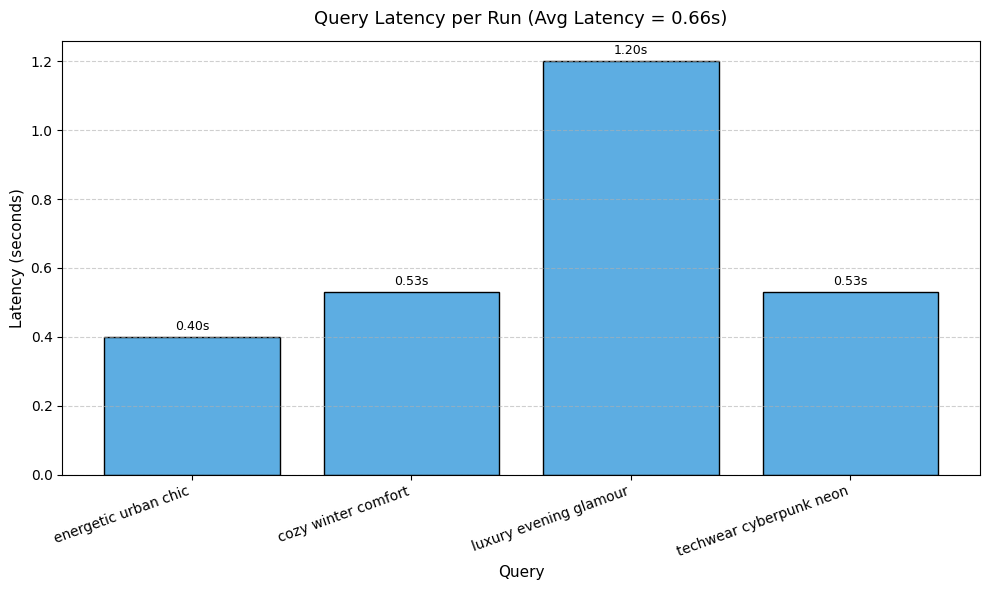

Average Latency: 0.66s


In [36]:
plot_query_latency()